In [1]:
#Import packages
#---------------------------------------
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
import tension
import tensorflow as tf #NB MUST BE TF < 3.11
from tension.constrained import ConstrainedNoFeedbackESN, BioFORCEModel
from sklearn.decomposition import PCA
import pkg_resources
%load_ext autoreload

#Display versions
#--------------------------------------
pkg_resources.get_distribution("tensorflow").version
sys.version

# Define paths
#----------------------------------------------------------------------
s_data = '/mnlsc/data/MCBL4/dburrows/'
s_code = '~/Documents/multiscale_dev_dynamics'


2023-03-15 11:00:46.275622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 11:00:47.336874: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-15 11:00:50.530826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-15 11:00:50.531520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

'3.7.4 (default, Aug 13 2019, 20:35:49) \n[GCC 7.3.0]'

# Load data

In [ ]:
# Filter out low SNR cells
# Gaussian smooth
# Find periods with highest SNR across recording -> choose a window
# Show low dim representation

In [27]:
import glob
os.chdir(s_data + '/dev/')
data_list = sorted(glob.glob('*regtrace*'))
data_list

['BLNDEV-WILDTYPE-01_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-03_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy',
 'BLNDEV-WILDTYPE-06_2photon_sess-01-6dpf_BLNGR_run-01_regtrace.npy']

In [23]:
data = np.load(data_list[0])

In [4]:
!wget https://data.mendeley.com/public-files/datasets/9936ryd5h7/files/7ac6616e-b6f7-4773-b254-b088147f68e6/file_downloaded 

--2023-03-15 11:01:18--  https://data.mendeley.com/public-files/datasets/9936ryd5h7/files/7ac6616e-b6f7-4773-b254-b088147f68e6/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/944fd3b3-cdd4-490d-a588-16392c862770 [following]
--2023-03-15 11:01:19--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/944fd3b3-cdd4-490d-a588-16392c862770
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.92.2.162, 52.92.19.50, 52.218.21.11, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.92.2.162|:443...

In [5]:
with np.load('file_downloaded', allow_pickle=True) as data:
  keys = ['mask_name', 'cell_ids', 'tracez', 'all_coords']
  i = -4 # index corresponding to desired data 
  cell_id = list(data['cell_ids'])[i]  
  print(data['mask_name'][i])
  print(data['tracez'].shape)
  print(data['tracez'][cell_id].shape) 
  target = data['tracez'][cell_id] # based on cell_id's of neurons in desired area of brain

Telencephalon - Subpallium
(11190, 2500)
(365, 2500)


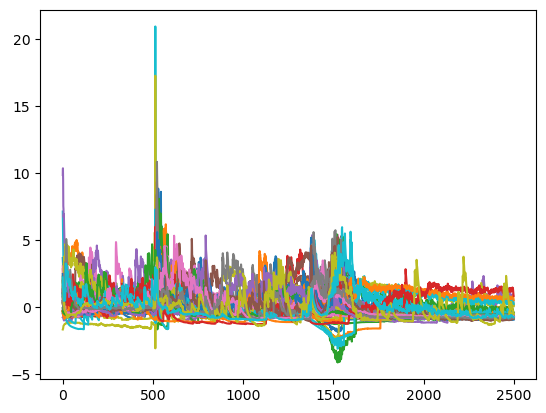

In [16]:
for i in range(50):
    plt.plot(target[i])
plt.show()

In [48]:
data.shape

AttributeError: 'NpzFile' object has no attribute 'shape'

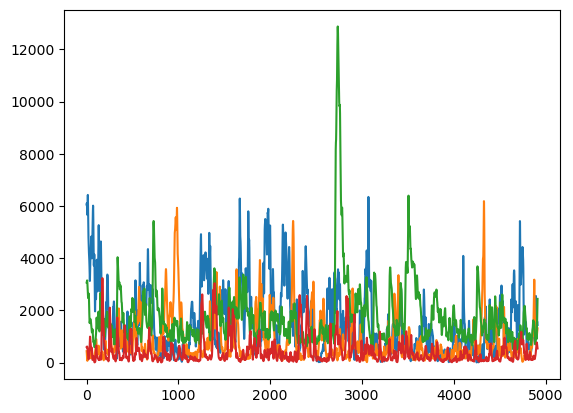

In [35]:
from scipy.ndimage import gaussian_filter1d
gf=3
for i in range(4):
    y = gaussian_filter1d(data[i], gf, axis = 0)
    plt.plot(y)
plt.show()

# Define training parameters

In [6]:
target_transposed = np.transpose(target).astype(np.float32) # convert to shape (timestep, number of neurons)
target_transposed.shape

(2500, 365)

In [7]:
u = 1 # number of inputs, by default the forward pass does not use inputs so this is a stand-in
n = target_transposed.shape[1] # number of neurons
tau = 1.5 # neuron time constant
dt = 0.25 # time step
alpha = 1 # gain on P matrix at initialization
m = n # output dim equals the number of recurrent neurons
g = 1.25 # gain parameter controlling network chaos
p_recurr = 0.5 # (1 - p_recurr) of recurrent weights are randomly set to 0 and not trained
max_epoch = 100

structural_connectivity = np.ones((n, n)) # region connectivity matrix; set to all 1's since only looking at one subsection of the brain
noise_param = (0, 0.001) # mean and std of white noise injected to the forward pass

x_t = np.zeros((target_transposed.shape[0], u)).astype(np.float32) # stand-in input

In [8]:
class EarlyStoppingByLossVal(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super().__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        
        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

# Train the model

In [15]:
x_t[:50].shape, target_transposed[:50].shape

((50, 1), (50, 365))

In [17]:
%%time
tf.random.set_seed(123)

earlystopping = EarlyStoppingByLossVal(monitor="val_mae", value=0.25)
esn_layer = ConstrainedNoFeedbackESN(units=n,
                                     activation='tanh',
                                     dtdivtau=dt/tau,
                                     p_recurr=p_recurr,
                                     structural_connectivity=structural_connectivity,
                                     noise_param=noise_param,
                                     seed=123)

model = BioFORCEModel(force_layer=esn_layer, alpha_P=alpha)
model.compile(metrics=["mae"])

# pass the input as validation data for early stopping
history = model.fit(x=x_t[:200], 
                    y=target_transposed[:200], 
                    epochs=max_epoch,
                    callbacks=[earlystopping],
                    validation_data=(x_t[:200], target_transposed[:200]))

Epoch 1/100
200/200 [==============================] - 40s 198ms/step - mae: 0.6331 - val_loss: 1.9513 - val_mae: 1.9513
Epoch 2/100
200/200 [==============================] - 29s 144ms/step - mae: 0.3478 - val_loss: 2.3138 - val_mae: 2.3138
Epoch 3/100
200/200 [==============================] - 32s 160ms/step - mae: 0.2538 - val_loss: 2.1800 - val_mae: 2.1800
Epoch 4/100
200/200 [==============================] - 32s 160ms/step - mae: 0.2140 - val_loss: 1.8527 - val_mae: 1.8527
Epoch 5/100
200/200 [==============================] - 27s 136ms/step - mae: 0.1797 - val_loss: 2.2250 - val_mae: 2.2250
Epoch 6/100
200/200 [==============================] - 25s 124ms/step - mae: 0.1662 - val_loss: 1.8140 - val_mae: 1.8140
Epoch 7/100
200/200 [==============================] - 26s 129ms/step - mae: 0.1583 - val_loss: 1.6937 - val_mae: 1.6937
Epoch 8/100
200/200 [==============================] - 26s 130ms/step - mae: 0.1370 - val_loss: 1.8575 - val_mae: 1.8575
Epoch 9/100
200/200 [===========

In [18]:
l

NameError: name 'l' is not defined

# Predict

In [21]:
%%time
prediction = model.predict(x_t[:200])
print(tf.math.reduce_mean(tf.keras.metrics.mean_absolute_error(prediction, target_transposed[:200])))

200/200 [==============================] - 0s 518us/step
tf.Tensor(0.20468557, shape=(), dtype=float32)
CPU times: user 247 ms, sys: 31.5 ms, total: 278 ms
Wall time: 208 ms


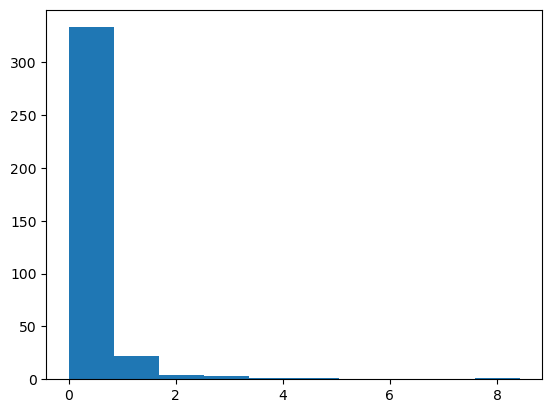

In [39]:
plt.hist(np.var(prediction,axis=0))
plt.show()

In [44]:
np.where(np.var(prediction,axis=0) > 3)[0]

array([  5,  34, 251, 309, 346])

Text(0.5, 0, 'Time (s)')

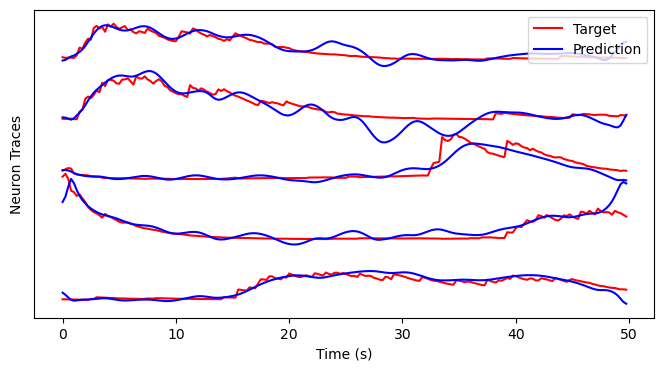

In [45]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
num_plot = np.where(np.var(prediction,axis=0) > 3)[0]

for idx, i in enumerate(num_plot):
  ax.plot(np.arange(0, x_t[:200].shape[0]) * dt, target_transposed[:200,i] + 10 * idx, color='r')
  ax.plot(np.arange(0, x_t[:200].shape[0]) * dt, prediction[:,i] + 10 * idx, color='b')
  if i == num_plot[-1]:
    ax.legend(['Target', 'Prediction'])
ax.set_yticks([])
ax.set_ylabel('Neuron Traces')
ax.set_xlabel('Time (s)')

Text(0, 0.5, 'PC2')

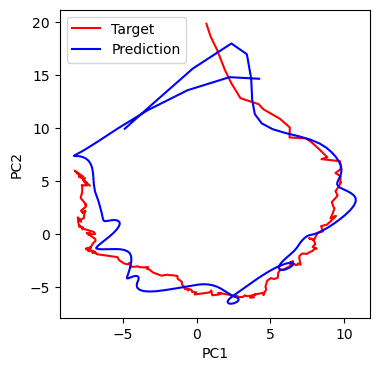

In [47]:
assert prediction.shape == target_transposed[:200].shape
pca = PCA(n_components=2)
target_pca = pca.fit_transform(target_transposed[:200])
pred_pca = pca.transform(prediction)
assert target_pca.shape == pred_pca.shape

plt.figure(figsize=(4,4))
plt.plot(target_pca[:,0], target_pca[:,1], color='r', label='Target')
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')

# Perturbation simulations